In [7]:
import numpy as np
import galsim
import matplotlib.pyplot as plt
from shrbk.data import get_galaxy_image

(section:deblending)=
# Deblending

## Definition

Blending is a phenomenon that happens in astronomical images when several objects are aligned when seen from Earth ; this causes the objects to be superposed on the images, making analysis of said objects difficult. Blending is of particular importance for weak lensing analysis, and even more so in next generation surveys which reach deeper magnitudes, tending to have more blended objects. This section is dedicated to methods which aim at recovering separate images of the objects in a blended scene ; you can find more about the impact of blending on shear measurement in {ref}`section:blendingbias`.

## Basic deblending

Here we will explore one of the most basic ways of doing deblending, using the software Source Extractor ({cite}`SExtractor`), which assigns each pixel to a source, which of course is not a perfect solution but is relatively easy to implement. Here is what the result looks like, using the package sep ({cite}`Barbary2016`), a python implementation of Source Extractor. We will reuse the same examples from {ref}`section:blendingbias` and use shear measurement results as a comparison.

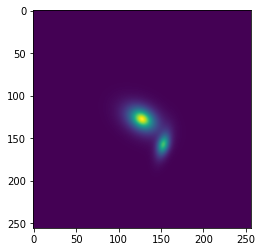

Shear measurement results : g1 =  0.10958495736122131 , g2 =  0.2798094153404236
Shear measurement error : δg1 =  9.585 %, δg2 =  39.905 %


In [8]:
image_central, image_psf = get_galaxy_image(gal_flux=1.e5,gal_r0=1.4,g1=0.1,g2=0.2,psf_beta=5,psf_re=1.0,
                                            pixel_scale=0.2)
image_companion, _ = get_galaxy_image(gal_flux=3.e4,gal_r0=0.6,g1=-0.5,g2=-0.3,psf_beta=5,psf_re=1.0,
                                            pixel_scale=0.2,shift_x=5,shift_y=6)
blended_scene = galsim.ImageD(256,256)
blended_scene += image_central
blended_scene += image_companion

plt.imshow(blended_scene.array)
plt.show()

measured_shear = galsim.hsm.EstimateShear(blended_scene,image_psf,shear_est='KSB')
print("Shear measurement results : g1 = ",measured_shear.corrected_g1,", g2 = ",measured_shear.corrected_g2)
print("Shear measurement error : \u03B4g1 = ",round((measured_shear.corrected_g1 - 0.1)/0.1 * 100,3),"%, \u03B4g2 = ",round((measured_shear.corrected_g2 - 0.2)/0.2*100,3),"%")

sep gives as a result a catalog containing the objects and a segmentation map associating each pixel with one of the galaxies (or to an empty area). We show the segmentation map obtained below.

In [9]:
import sep
img = blended_scene.array
cat,segmentation = sep.extract(img,2,segmentation_map=True)

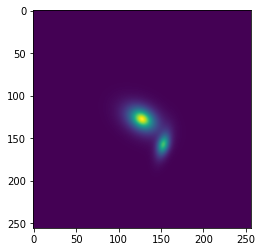

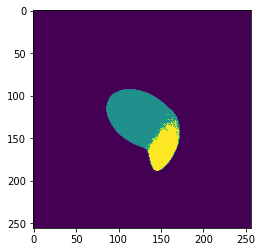

In [10]:
plt.imshow(blended_scene.array)
plt.show()
plt.imshow(segmentation)
plt.show()

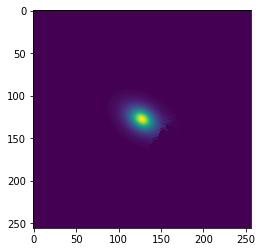

Shear measurement results : g1 =  0.10152844339609146 , g2 =  0.19612617790699005
Shear measurement error : δg1 =  1.528 %, δg2 =  -1.937 %


In [11]:
masked_scene = blended_scene.array * np.where(segmentation == 1, 1, 0)
plt.imshow(masked_scene)
plt.show()
measured_shear = galsim.hsm.EstimateShear(galsim.Image(masked_scene),image_psf,shear_est='KSB')
print("Shear measurement results : g1 = ",measured_shear.corrected_g1,", g2 = ",measured_shear.corrected_g2)
print("Shear measurement error : \u03B4g1 = ",round((measured_shear.corrected_g1 - 0.1)/0.1 * 100,3),"%, \u03B4g2 = ",round((measured_shear.corrected_g2 - 0.2)/0.2*100,3),"%")

As you can see, the recovered image is close to the original galaxy and shape measurement is not really affected once the galaxy is deblended. However, this first example was manageable because the two galaxies were only blended a little. Let's see the result when the galaxies overlap more completely.

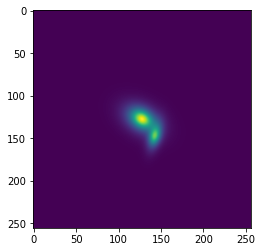

Shear measurement results : g1 =  -0.03829635679721832 , g2 =  0.4417387545108795
Shear measurement error : δg1 =  -138.296 %, δg2 =  120.869 %


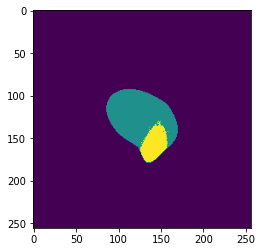

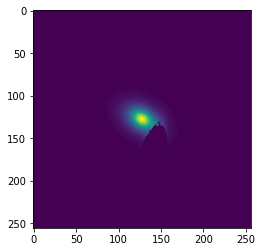

Shear measurement results : g1 =  0.1317169964313507 , g2 =  0.13085855543613434
Shear measurement error : δg1 =  31.717 %, δg2 =  -34.571 %


In [12]:
image_companion, _ = get_galaxy_image(gal_flux=3.e4,gal_r0=0.6,g1=-0.5,g2=-0.3,psf_beta=5,psf_re=1.0,
                                            pixel_scale=0.2,shift_x=3,shift_y=4)
blended_scene = galsim.ImageD(256,256)
blended_scene += image_central
blended_scene += image_companion

plt.imshow(blended_scene.array)
plt.show()

measured_shear = galsim.hsm.EstimateShear(blended_scene,image_psf,shear_est='KSB')
print("Shear measurement results : g1 = ",measured_shear.corrected_g1,", g2 = ",measured_shear.corrected_g2)
print("Shear measurement error : \u03B4g1 = ",round((measured_shear.corrected_g1 - 0.1)/0.1 * 100,3),"%, \u03B4g2 = ",round((measured_shear.corrected_g2 - 0.2)/0.2*100,3),"%")

img = blended_scene.array
cat,segmentation = sep.extract(img,2,segmentation_map=True)
plt.imshow(segmentation)
plt.show()

masked_scene = blended_scene.array * np.where(segmentation == 1, 1, 0)
plt.imshow(masked_scene)
plt.show()
measured_shear = galsim.hsm.EstimateShear(galsim.Image(masked_scene),image_psf,shear_est='KSB')
print("Shear measurement results : g1 = ",measured_shear.corrected_g1,", g2 = ",measured_shear.corrected_g2)
print("Shear measurement error : \u03B4g1 = ",round((measured_shear.corrected_g1 - 0.1)/0.1 * 100,3),"%, \u03B4g2 = ",round((measured_shear.corrected_g2 - 0.2)/0.2*100,3),"%")

This time, a significant part of the central galaxy has been removed in the deblending process. This leads to a wildly inaccurate shear measurement. Let's see what happens when we bring the galaxies even closer to each other.

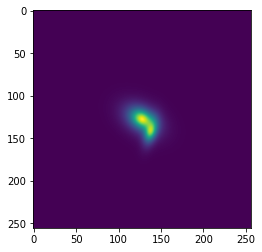

Shear measurement results : g1 =  -0.053492192178964615 , g2 =  0.30959129333496094


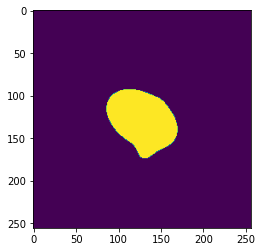

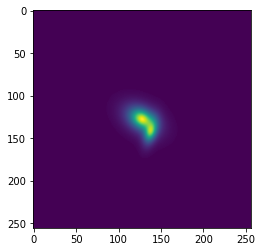

Shear measurement results : g1 =  -0.05296389013528824 , g2 =  0.30788126587867737


In [13]:
image_companion, _ = get_galaxy_image(gal_flux=3.e4,gal_r0=0.6,g1=-0.5,g2=-0.3,psf_beta=5,psf_re=1.0,
                                            pixel_scale=0.2,shift_x=2,shift_y=3)
blended_scene = galsim.ImageD(256,256)
blended_scene += image_central
blended_scene += image_companion

plt.imshow(blended_scene.array)
plt.show()

measured_shear = galsim.hsm.EstimateShear(blended_scene,image_psf,shear_est='KSB')
print("Shear measurement results : g1 = ",measured_shear.corrected_g1,", g2 = ",measured_shear.corrected_g2)

img = blended_scene.array
cat,segmentation = sep.extract(img,2,segmentation_map=True)
plt.imshow(segmentation)
plt.show()

masked_scene = blended_scene.array * np.where(segmentation == 1, 1, 0)
plt.imshow(masked_scene)
plt.show()
measured_shear = galsim.hsm.EstimateShear(galsim.Image(masked_scene),image_psf,shear_est='KSB')
print("Shear measurement results : g1 = ",measured_shear.corrected_g1,", g2 = ",measured_shear.corrected_g2)

Here, SExtractor has been unable to perform deblending and identified the two galaxies as a single object. This situation is commonly called an "unrecognized blend" ; these are the most challenging blending situations to manage in a weak lensing survey as it is impossible to properly managed the blend, since it has not been identified.